# Tutorial Ejercicio 1: Transfer Learning y Fine-Tuning con Keras

Tutorial de Transfer Learning y Fine Tuning.

[Máster en Data Science y Big Data](http://masterds.es/) de la [Universidad de Sevilla](http://www.us.es). 

[Miguel Ángel Martínez del Amor](http://www.cs.us.es/~mdelamor)

## Tabla de Contenidos

* [1. Transfer Learning con Keras y VGG16](#transfer)
  * [1.1 Importación de librerías](#transferimp)
  * [1.2 El modelo pre-entrenado: VGG16](#transfermodel)
  * [1.3 El dataset: Knifey-Spoony](#transferdata)
  * [1.4 El canal de entrada](#transferinput)
  * [1.5 Las clases del dataset](#transferclases)
  * [1.6 Ejemplos de predicción](#transferej)
  * [1.7 Transfer Learning](#transfertl)
  * [1.8 Fine Tuning](#transferft)
  * [1.9 Conclusiones](#transferconclu)

## 1. Transfer Learning con Keras y VGG16 <a class="anchor" id="transfer"></a>

En este apartado del tutorial vamos a reutilizar un modelo pre-entrenado para clasificar imágenes de un conjunto de datos nuevo. Podéis ver más información sobre los modelos pre-entrenados en Keras en [este enlace](https://keras.io/applications/).

Usaremos el modelo VGG16, que consiste en varias capas convolucionales (en realidad bloques de capas convolucionales múltiples), seguidas por algunas capas completamente conectadas (densas) y luego una capa de salida softmax para la clasificación. 

Las capas densas son responsables de combinar los rasgos de las capas convolucionales y esto ayuda en la clasificación final. Así que cuando el modelo VGG16 se utiliza en otro conjunto de datos, es posible que tengamos que reemplazar todas las capas densas. En este caso añadimos otra capa densa y una capa dropout para evitar el sobreajuste.

La diferencia entre Transfer Learning y Fine-Tuning es que en Transfer Learning sólo optimizamos los pesos de las nuevas capas de clasificación que hemos añadido, mientras que mantenemos los pesos del modelo original VGG16. En Fine-Tuning optimizamos tanto los pesos de las nuevas capas de clasificación que hemos añadido, como algunas o todas las capas del modelo VGG16.

![Flowchart of Transfer Learning & Fine-Tuning](images/10_transfer_learning_flowchart.png)

### 1.1 Importación de librerías y funciones auxiliares <a class="anchor" id="transferimp"></a>

#### 1.1.1 Librerías

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

A continuación la importación de la API de Keras. Comprueba como se hace la importación directamente desde TensorFlow.

In [2]:
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop

tf.__version__

Using TensorFlow backend.


'1.13.1'

Comprobemos si estamos usando GPU desde TensorFlow. Debería aparecer `/device:GPU:X`, donde X es un número (0, 1,...) según existen más GPUs en el sistema.

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

#### 1.1.2 Funciones auxiliares de ayuda

Para unir un directorio con una lista de nombres de fichero.

In [4]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

Para dibujar imágenes, definimos esta función que usa una gráfica con hasta 9 imágenes en un grid de 3x3, y escribe la clase de verdad y las predecidas en cada imagen.

In [5]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Función para mostrar un matriz de confusión. La emplearemos para mostrar las frecuencias de las confusiones entre las clases por el predictor.

In [6]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

Función para mostrar ejemplos de imagenes del conjunto de test que han sido mal clasificadas (errores).

In [7]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

Función para calcular las clases pronosticadas de todo el conjunto de test y llamar a la función anterior para dibujar algunos ejemplos de imágenes mal clasificadas.

In [8]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

Función de ayuda para cargar imágenes. El conjunto de datos no se carga en la memoria, sino que tiene una lista de los archivos de las imágenes del conjunto de entrenamiento y otra lista de los archivos de las imágenes del conjunto de pruebas. Esta función de ayuda carga algunos archivos de imagen.

In [9]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

Función de ayuda para trazar el historial de entrenamiento. Esto traza la precisión de clasificación y los valores de pérdida registrados durante el entrenamiento con la API de Keras.

In [10]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

### 1.2 El Modelo Pre-Entrenado: VGG16  <a class="anchor" id="transfermodel"></a>

Lo siguiente crea una instancia del modelo VGG16 pre-entrenado usando la API de [Keras](https://keras.io/). Esto descarga automáticamente los archivos necesarios si no los tiene ya. 

El modelo VGG16 contiene una parte convolucional y una parte completamente conectada (o densa) que se utiliza para la clasificación. Si `include_top=True` entonces se descarga todo el modelo VGG16 que tiene unos 528 MB. Si `include_top=False` entonces sólo se descarga la parte convolucional del modelo VGG16, que es de sólo 57 MB.

Intentaremos usar el modelo pre-entrenado para predecir la clase de algunas imágenes en nuestro nuevo conjunto de datos, así que tenemos que descargar el modelo completo, pero si tienes una conexión lenta a Internet, entonces puedes modificar el código de abajo para usar el modelo pre-entrenado más pequeño sin las capas de clasificación.

![VGG model](images/11_vgg_model.png)

In [11]:
model = VGG16(include_top=True, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


### 1.3 El Dataset: Knifey-Spoony <a class="anchor" id="transferdata"></a>

Para demostrar como usar transfer learning y fine tuning, usaremos un nuevo conjunto de datos llamado [Knifey-Spoony](https://github.com/Hvass-Labs/knifey-spoony) que contiene miles de imágenes de cuchillos, cucharas y tenedores sobre unos cuantos fondos diferentes. El conjunto de entrenamiento (training) contiene 4.170 imágenes y el de pruebas (test) 530 imágenes. Las clases se denominan knifey, spoony y forky como referencia a [Los Simpsons](https://www.youtube.com/watch?v=mcE0aAhbVFc).

Las imágenes en el conjunto de datos knifey-spoony fueron creadas a partir de archivos de vídeo usando un pequeño [script de Python](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/convert.py) que se ejecuta en Linux (requiere el programa `avconv` para la conversión de videos a imágenes). Esto le permite crear fácilmente conjuntos de datos muy grandes con miles de imágenes de sólo unos minutos de grabaciones de vídeo.

La descarga y la extracción del dataset ya viene automatizado en el fichero [`knifey.py`](./knifey.py)

In [12]:
# Carga el dataset empleando el fichero kinfey.py
import knifey

Descarga y extrae el dataset si aún no se ha hecho. Ocupa unos 22 MB. A continuación, mostramos el contenido de la carpeta extraida.

In [13]:
knifey.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [14]:
!echo "El contenido de la carpeta es: "
!ls data/knifey-spoony
!echo "Por ejemplo, la carpeta forky contiene: "
!ls data/knifey-spoony/forky

El contenido de la carpeta es: 
forky			    knifey		  README.md  train
inception-knifey-test.pkl   knifey-spoony.pkl	  spoony
inception-knifey-train.pkl  knifey-spoony.tar.gz  test
Por ejemplo, la carpeta forky contiene: 
forky-01-0001.jpg  forky-02-0049.jpg  forky-03-0113.jpg  forky-04-0191.jpg
forky-01-0002.jpg  forky-02-0050.jpg  forky-03-0114.jpg  forky-04-0192.jpg
forky-01-0003.jpg  forky-02-0051.jpg  forky-03-0115.jpg  forky-04-0193.jpg
forky-01-0004.jpg  forky-02-0052.jpg  forky-03-0116.jpg  forky-05-0001.jpg
forky-01-0005.jpg  forky-02-0053.jpg  forky-03-0123.jpg  forky-05-0002.jpg
forky-01-0006.jpg  forky-02-0054.jpg  forky-03-0124.jpg  forky-05-0003.jpg
forky-01-0007.jpg  forky-02-0055.jpg  forky-03-0125.jpg  forky-05-0004.jpg
forky-01-0008.jpg  forky-02-0056.jpg  forky-03-0126.jpg  forky-05-0005.jpg
forky-01-0009.jpg  forky-02-0057.jpg  forky-03-0127.jpg  forky-05-0006.jpg
forky-01-0010.jpg  forky-02-0058.jpg  forky-03-0128.jpg  forky-05-0007.jpg
forky-01-0011.jpg  forky-02-

Este dataset tiene una estructura de directoris distinta que la requerida por Keras, por tanto copiaremos los ficheros en directorios separados para los conjuntos de pruebas (training) y pruebas (test). Esto ya está automatizado.

In [15]:
knifey.copy_files()

Creating dataset from the files in: data/knifey-spoony/
- Data loaded from cache-file: data/knifey-spoony/knifey-spoony.pkl
- Copied training-set to: data/knifey-spoony/train/
- Copied test-set to: data/knifey-spoony/test/


Finalmente, extraemos los directorios donde están las imágenes.

In [16]:
train_dir = knifey.train_dir
test_dir = knifey.test_dir

### 1.4 El Canal de Entrada <a class="anchor" id="transferinput"></a>

La API de Keras tiene su propia manera de crear el pipeline de entrada para entrenar un modelo usando ficheros.

Primero necesitamos saber la forma de los tensores esperados como entrada por el modelo VGG16 pre-entrenado. En este caso se trata de imágenes de forma 224 x 224 x 3.

In [17]:
input_shape = model.layers[0].output_shape[1:3]
input_shape

(224, 224)

Keras utiliza un llamado *generador de datos* para introducir datos en la red neuronal, que iterará sobre los datos durante toda la eternidad.

Tenemos un pequeño conjunto de entrenamiento, así que el generador ayudará a inflar artificialmente su tamaño haciendo varias transformaciones en las imágenes. Utilizaremos un generador de datos incorporado que puede realizar estas transformaciones aleatorias. Esto también se llama **aumentado de datos** (data augmentation).

Busca en la [ayuda de Keras](https://keras.io/preprocessing/image/) qué parámetros se pueden configurar en el generador de datos.

In [18]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

También necesitamos un generador de datos para el conjunto de test, pero esto no debería hacer ninguna transformación en las imágenes porque queremos saber la precisión exacta de la clasificación en esas imágenes específicas. Así que simplemente reescalamos los valores de los píxeles para que estén entre 0,0 y 1,0 porque esto es lo que se espera en el modelo VGG16.

In [19]:
datagen_test = ImageDataGenerator(rescale=1./255)

Los generadores de datos devolverán batches (lotes) de imágenes. Debido a que el modelo VGG16 es muy grande, el tamaño del batch no puede ser demasiado grande, ya que de lo contrario nos quedaremos sin RAM en la GPU.

In [20]:
batch_size = 20

Podemos guardar las imágenes transformadas aleatoriamente durante el entrenamiento, para comprobar si han sido demasiado distorsionadas, por lo que tendríamos que ajustar los parámetros del generador de datos anterior.

In [21]:
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

Ahora creamos el generador de datos real que leerá los archivos del disco, redimensionará las imágenes y devolverá un lote aleatorio.

Es un poco incómodo que la construcción del generador de datos se divida en estos dos pasos, pero probablemente se deba a que hay diferentes tipos de generadores de datos disponibles para diferentes tipos de datos (imágenes, texto, etc.) y fuentes (memoria o disco).

In [22]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 4170 images belonging to 3 classes.


El generador de datos para el conjunto de test no debería transformar y mezclar las imágenes.

In [23]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 530 images belonging to 3 classes.


Debido a que los generadores de datos iteran para siempre, necesitamos especificar el número de pasos a realizar durante la evaluación y predicción en el conjunto de pruebas. Debido a que nuestro conjunto de pruebas contiene 530 imágenes y el tamaño del batch está configurado en 20, el número de pasos es 26,5 para un procesamiento completo del conjunto de pruebas. Por eso necesitamos reiniciar el contador del generador de datos en la función `example_errors()` de arriba, para que siempre comience a procesar desde el principio del conjunto de pruebas.

In [24]:
steps_test = generator_test.n / batch_size
steps_test

26.5

### 1.5 Clases del Conjunto de Datos <a class="anchor" id="transferclases"></a>

Obtengamos las rutas de los ficheros para todas las imágenes en los conjuntos de entrenamiento y de pruebas.

In [25]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

Obtengamos también las clasificaciones reales (el número correspondiente) de cada imagen en los conjuntos de training y test.

In [26]:
cls_train = generator_train.classes
cls_test = generator_test.classes

Obtengamos los nombres correspondientes de las clases del dataset.

In [27]:
class_names = list(generator_train.class_indices.keys())
class_names

['forky', 'knifey', 'spoony']

Por último, obtener el número de clases en el dataset.

In [28]:
num_classes = generator_train.num_classes
num_classes

3

Mostremos algunas imágenes para ver si los datos son correctos.

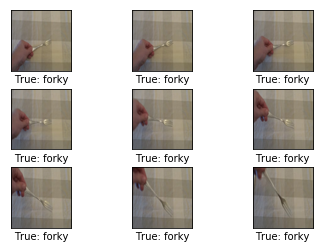

In [29]:
# Carga las primeras imágenes del conjunto de training
images = load_images(image_paths=image_paths_train[0:9])

# Obtiene las clases verdades de cada una de esas imágenes.
cls_true = cls_train[0:9]

# Muestra las imágenes y las etiquetas con la función auxiliar correspondiente.
plot_images(images=images, cls_true=cls_true, smooth=True)

El conjunto de datos Knifey-Spoony está bastante desequilibrado porque tiene pocas imágenes de tenedores, más imágenes de cuchillos y muchas más imágenes de cucharas. Esto puede causar un problema durante el entrenamiento porque a la red neural se le mostrará muchos más ejemplos de cucharas que de tenedores, por lo que puede llegar a ser mejor en el reconocimiento de las cucharas.

Aquí usamos scikit-learn para calcular **pesos** que equilibrarán adecuadamente el conjunto de datos. Estos pesos se aplican al gradiente para cada imagen del lote durante el entrenamiento, de manera que se pueda escalar su influencia en el gradiente global del lote.

In [30]:
from sklearn.utils.class_weight import compute_class_weight

In [31]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

Observa que el peso es de aproximadamente 1,398 para la clase tenedor y sólo 0,707 para la clase cuchara. Esto se debe a que hay menos imágenes para la clase tenedor, por lo que el gradiente debe ser amplificado para esas imágenes, mientras que el gradiente debe ser bajado para las imágenes de cuchara.

In [32]:
class_weight

array([1.39839034, 1.14876033, 0.70701933])

In [33]:
class_names

['forky', 'knifey', 'spoony']

### 1.6 Ejemplos de Predicción <a class="anchor" id="transferej"></a>

Aquí mostraremos algunos ejemplos de uso del modelo VGG16 para la predicción de algunas imágenes. Necesitamos una función de ayuda para cargar y redimensionar una imagen para que pueda ser introducida en el modelo VGG16, así como para hacer la predicción real y mostrar el resultado.

In [34]:
def predict(image_path):
    # Carga y redimensiona la imagen usando PIL.
    img = PIL.Image.open(image_path)
    #input_shape = model.layers[0].output_shape[1:3]
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Dibuja la imagen.
    plt.imshow(img_resized)
    plt.show()

    # Convierte la imagen PIL a un numpy-array con la forma (shape) apropiada.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Usa el modelo VGG16 para hacer la predicción.
    # Esto devuelve un array con 1000 números, correspondientes a
    # las clases del dataset ImageNet.
    pred = model.predict(img_array)
    
    # Decodifica la salida del modelo VGG16.
    pred_decoded = decode_predictions(pred)[0]

    # Imprime las predicciónes.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

Usemos el modelo VGG16 en la foto del loro que está clasificado como guacamayo (macaw, una especie de loro) con una puntuación bastante alta de 79%.

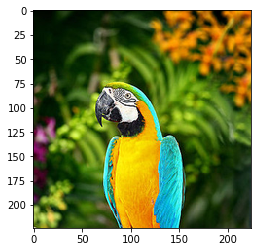

79.02% : macaw
 6.61% : bubble
 3.64% : vine_snake
 1.90% : pinwheel
 1.22% : knot


In [35]:
predict(image_path='images/parrot_cropped1.jpg')

Entonces podemos usar el modelo VGG16 para predecir la clase de una de las imágenes en nuestro nuevo conjunto de entrenamiento. 

El modelo VGG16 está muy confundido sobre esta imagen y no puede hacer una buena clasificación. Con un 54,03% de confianza cree que se trata de una cortina de ducha (shower_curtain). Quizás no le falte razón, pero está perdiendo la perspectiva del tenedor.

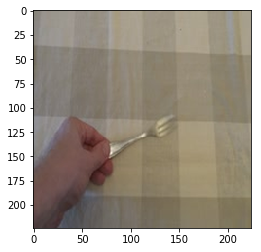

54.02% : shower_curtain
16.04% : handkerchief
10.37% : mosquito_net
 2.59% : window_shade
 1.35% : toilet_tissue


In [36]:
predict(image_path=image_paths_train[0])

Podemos intentarlo con otra imagen en nuestro nuevo set de entrenamiento, pero el modelo VGG16 todavía está confundido.

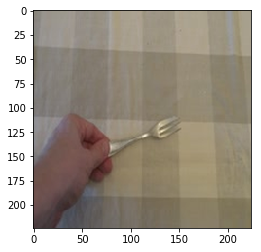

48.31% : shower_curtain
20.17% : mosquito_net
10.17% : handkerchief
 1.97% : window_shade
 1.01% : bathtub


In [37]:
predict(image_path=image_paths_train[1])

También podemos probar una imagen de nuestro nuevo conjunto de pruebas, y de nuevo el modelo VGG16 está muy confundido. A lo máximo que llega con un 25,44%, es una espátula (spoonbill).

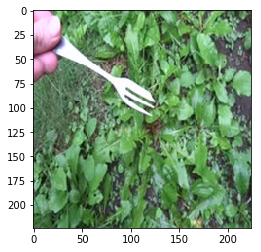

25.44% : spoonbill
 7.95% : wooden_spoon
 6.74% : black_stork
 4.09% : limpkin
 3.86% : paddle


In [38]:
predict(image_path=image_paths_test[0])

### 1.7 Transfer Learning <a class="anchor" id="transfertl"></a>

El modelo VGG16 preentrenado no pudo clasificar las imágenes del conjunto de datos Knifey-Spoony. La razón es quizás que el modelo VGG16 fue entrenado en el dataset ImageNet, que puede no haber contenido muchas imágenes de cubiertos.

Las capas inferiores de una Red Neural Convolucional pueden reconocer muchas formas o características diferentes en una imagen. Son las últimas capas completamente conectadas las que combinan estas características en la clasificación de una imagen completa. Así que podemos intentar redirigir la salida de la última capa convolucional del modelo VGG16 a una nueva red neuronal completamente conectada *(fully-connected)* que creamos para hacer la clasificación en el conjunto de datos de Knifey-Spoony.

Primero imprimimos un resumen del modelo VGG16 para poder ver los nombres y tipos de sus capas, así como las formas de los tensores que fluyen entre las capas. Esta es una de las razones principales por las que estamos comenzando usando el modelo VGG16 en este tutorial, porque el modelo Inception v3 tiene tantas capas que puede ser confuso cuando se imprime.

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Podemos ver que la última capa convolucional se llama 'block5_pool', y podemos usar Keras para obtener una referencia a dicha capa.

In [40]:
transfer_layer = model.get_layer('block5_pool')

Nos referiremos a esta capa como la Capa de Transferencia (**Transfer Layer**), puesto que su salida será re-enrutada a nuestra nueva red neuronal completamente conectada que hará la clasificación final sobre el Knifey-Spoony dataset.

La salida de la capa de transferencia tiene la siguiente forma:

In [41]:
transfer_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

Es muy sencillo crear un nuevo modelo usando la API de Keras. Primero tomamos la parte del modelo VGG16 desde su capa de entrada hasta la salida de la capa de transferencia. Podemos llamarlo el modelo convolucional, porque consiste en todas las capas convolucionales del modelo VGG16.

In [42]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

Podemos entonces usar Keras para construir un modelo nuevo encima de este.

In [43]:
# Creamos un nuevo modelo Secuencial de Keras
new_model = Sequential()

# Añadimos la parte convolucional del modelo VGG16 de arriba
new_model.add(conv_model)

# Aplanamos la salida del modelo VGG16 dado que ésta viene
# de una capa convolucional.
new_model.add(Flatten())

# Añade una capa densa (es decir, totalmente conectada o fully-connected).
# Esto es para combinar las características que el modelo VGG16 ha
# reconocido en la imagen.
new_model.add(Dense(1024, activation='relu'))

# Añade una capa dropout el cual prevendrá el sobreajuste y mejorará
# la capacidad de generalización en datos desconocidos (es decir, el 
# conjunto de test)
new_model.add(Dropout(0.5))

# Añade la capa final para la clasificación real, usando softmax.
new_model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Utilizamos el optimizador Adam con una tasa de aprendizaje bastante baja. La tasa de aprendizaje podría ser mayor, pero si se intenta entrenar más capas del modelo original VGG16, entonces la velocidad de aprendizaje debería ser bastante baja, de lo contrario los pesos preentrenados del modelo VGG16 se distorsionarán y no podrá aprender.

In [44]:
optimizer = Adam(lr=1e-5)

Tenemos 3 clases en el Knifey-Spoony dataset, por lo que Keras necesita usar esta **función de pérdida** (loss function).

In [45]:
loss = 'categorical_crossentropy'

La única **métrica de rendimiento** en la que estamos interesados es en la precisión de clasificación (clasiffication accuracy).

In [46]:
metrics = ['categorical_accuracy']

Función auxiliar para imprimir si la capa en el modelo VGG16 debe ser entrenada.

In [47]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

Por defecto, todas las capas del modelo VGG16 son entrenables.

In [48]:
print_layer_trainable()

False:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


En transfer learning estamos inicialmente interesados tan solo en reusar el modelo VGG16 tal cual, como un **extractor de características**, por lo que deshabilitaremos el entrenamiento en todas sus capas.

In [49]:
conv_model.trainable = False

In [50]:
for layer in conv_model.layers:
    layer.trainable = False

In [51]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


Una vez que hayamos cambiado si las capas del modelos son entrenables, necesitamos compilarlo para que los cambios surtan efecto.

In [52]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Una **época** (epoch) normalmente significa un procesamiento completo del conjunto de entrenamiento. Pero el generador de datos que creamos arriba, producirá batches de datos de entrenamiento para la eternidad. Por lo tanto, necesitamos definir el número de pasos que queremos ejecutar para cada "época" y este número se multiplica por el tamaño de batch definido anteriormente. En este caso tenemos 100 pasos por época y un tamaño de batch de 20, por lo que la "época" consiste en 2.000 imágenes aleatorias del conjunto de entrenamiento. Nosotros ejecutaremos 20 de esas "épocas".

La razón por la que se eligieron estos números en particular, fue porque parecían ser suficientes para entrenar con este modelo y el conjunto de datos en particular, lo que no llevó mucho tiempo, y resultó en 20 puntos de datos (uno para cada "época") que se pueden mostrar después.

In [53]:
epochs = 20
steps_per_epoch = 100

A continuación entrenamos el nuevo modelo, lo que se hace con tan solo una llamada a una función en la API de Keras. Esto tomará algunos minutos... (sobre unos 7 en una GTX1070)

In [54]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
100/100 [==============================] - 40s 401ms/step - loss: 1.1516 - categorical_accuracy: 0.4280 - val_loss: 0.8836 - val_categorical_accuracy: 0.5321
Epoch 2/20
100/100 [==============================] - 36s 364ms/step - loss: 0.9602 - categorical_accuracy: 0.5450 - val_loss: 0.8381 - val_categorical_accuracy: 0.6302
Epoch 3/20
100/100 [==============================] - 36s 363ms/step - loss: 0.8400 - categorical_accuracy: 0.6020 - val_loss: 0.8199 - val_categorical_accuracy: 0.5962
Epoch 4/20
100/100 [==============================] - 36s 365ms/step - loss: 0.7904 - categorical_accuracy: 0.6530 - val_loss: 0.7238 - val_categorical_accuracy: 0.7019
Epoch 5/20
100/100 [==============================] - 36s 363ms/step - loss: 0.7614 - categorical_accuracy: 0.6605 - val_loss: 0.7075 - val_categorical_accuracy: 0.6943
Epoch 6/20
100/100 [==============================] - 37s 372ms/step - loss: 0.7187 - categorical_accuracy:

Keras registra las métricas de rendimiento al final de cada "época" para que puedan ser mostradas en gráficos posteriormente. Esto muestra que la pérdida de valor del conjunto de entrenamiento generalmente disminuyó durante el entrenamiento, pero la pérdida de valor del conjunto de pruebas fue un poco más errática. De manera similar, la precisión de la clasificación mejoró en general en el conjunto de entrenamiento, mientras que fue un poco más errática en el conjunto de pruebas.

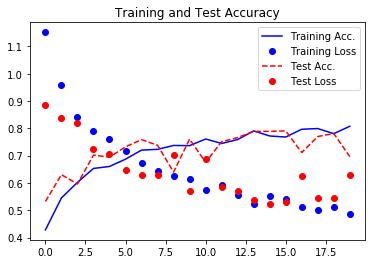

In [55]:
plot_training_history(history)

Después del entrenamiento también podemos evaluar el rendimiento del nuevo modelo en el conjunto de pruebas usando una sola llamada de función en la API de Keras.

In [56]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [57]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 69.62%


Podemos representar algunos ejemplos de imágenes mal clasificadas del conjunto de pruebas. Algunas de estas imágenes también son difíciles de clasificar para un humano.

La matriz de confusión muestra que el nuevo modelo está teniendo especialmente problemas para clasificar la clase *knifey* (cuchillo), donde la mayoría de las confusiones vienen dadas por la clase *forky* (tenedor). Recordad que hemos usado sk-learn para representar la matriz, y las filas son clases verdades y las columnas clases predecidas.

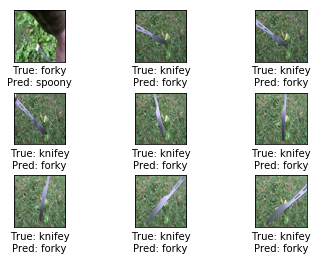

Confusion matrix:
[[150   0   1]
 [ 83  53   1]
 [ 71   5 166]]
(0) forky
(1) knifey
(2) spoony


In [58]:
example_errors()

### 1.8 Fine-Tuning <a class="anchor" id="transferft"></a>

En Transfer Learning, el modelo original pre-entrenado se bloquea o congela durante el entrenamiento del nuevo clasificador. Esto asegura que los pesos del modelo original VGG16 no cambiarán. Una ventaja de esto es que el entrenamiento del nuevo clasificador no propagará grandes gradientes a través del modelo VGG16, lo que puede distorsionar sus pesos o causar un sobreajuste en el nuevo conjunto de datos.

Pero una vez que el nuevo clasificador ha sido entrenado, podemos tratar de afinar suavemente algunas de las capas más profundas del modelo VGG16 también. A esto lo llamamos "Ajuste fino", o **Fine Tuning**.

No está claro si Keras usa el booleano `trainable` en cada capa del modelo original VGG16 o si es anulado por el booleano `trainable` en la'meta-capa' que llamamos `conv_layer`. Así que habilitaremos el booleano `trainable` tanto para `conv_layer` como para todas las capas relevantes en el modelo original VGG16.

In [59]:
conv_model.trainable = True

Queremos entrenar las últimas dos capas convolucionales, es decir, cuyos nombres contienen 'block5' o 'block4'.

In [60]:
for layer in conv_model.layers:
    # Booleano de si la capa es entrenable
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Ajusta el booleano de la capa
    layer.trainable = trainable

Podemos comprobar que esto ha actualizado el booleano `trainable` para las capas relevantes.

In [61]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


Usaremos un bajo factor de aprendizaje para el ajuste fino, por lo que los pesos del modelo VGG16 original solo cambiará muy lentamente.

In [62]:
optimizer_fine = Adam(lr=1e-7)

Dado que hemos definido un nuevo optimizador y hemos cambiado los booleanos `trainable` para muchas de las capas en el modelo, necesitamos recompilarlo para que los cambios hagan efecto.

In [63]:
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

Continuamos por tanto con el entrenamiento por donde lo dejamos anteriormente, ahora aplicando fine-tuning al modelo VGG16 y el nuevo clasificador.

In [64]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/20
100/100 [==============================] - 52s 523ms/step - loss: 0.4721 - categorical_accuracy: 0.8085 - val_loss: 0.5586 - val_categorical_accuracy: 0.7566
Epoch 2/20
100/100 [==============================] - 50s 503ms/step - loss: 0.4560 - categorical_accuracy: 0.8110 - val_loss: 0.5560 - val_categorical_accuracy: 0.7604
Epoch 3/20
100/100 [==============================] - 50s 502ms/step - loss: 0.4564 - categorical_accuracy: 0.8235 - val_loss: 0.5493 - val_categorical_accuracy: 0.7642
Epoch 4/20
100/100 [==============================] - 50s 504ms/step - loss: 0.4568 - categorical_accuracy: 0.8160 - val_loss: 0.5486 - val_categorical_accuracy: 0.7660
Epoch 5/20
100/100 [==============================] - 50s 502ms/step - loss: 0.4360 - categorical_accuracy: 0.8160 - val_loss: 0.5335 - val_categorical_accuracy: 0.7717
Epoch 6/20
100/100 [==============================] - 50s 504ms/step - loss: 0.4466 - categorical_accuracy: 0.8245 - val_loss: 0.5308 - val_categorical_acc

Luego podemos mostrar gráficamente los valores de pérdida y precisión de la clasificación a partir del entrenamiento. Dependiendo del conjunto de datos, el modelo original, el nuevo clasificador y los hiperparámetros como la velocidad de aprendizaje, esto puede mejorar las precisiones de clasificación tanto en el conjunto de entrenamiento como en el de pruebas, o puede mejorar el conjunto de entrenamiento pero empeorarla en el conjunto de pruebas en caso de sobreajuste. Es posible que se requiera cierta experimentación con los parámetros para hacer esto bien.

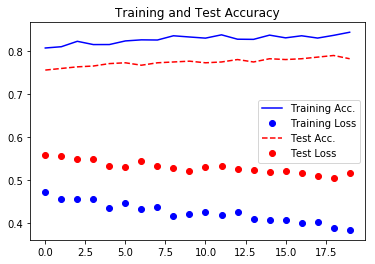

In [65]:
plot_training_history(history)

In [66]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [67]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 78.30%


Podemos volver a mostrar algunos ejemplos de imágenes mal clasificadas, y también podemos ver en la matriz de confusión que el modelo sigue teniendo problemas para clasificar correctamente los cuchillos y las cucharas, siendo muchas veces confundidos por los tenedores.

Una parte de la razón podría ser que el conjunto de entrenamiento contiene sólo 994 imágenes de tenedores, mientras que contiene 1.210 imágenes de cuchillos e imágenes de cucharas de 1.966. Aunque hemos ponderado las clases para compensar este desequilibrio, y también hemos aumentado el conjunto de entrenamiento transformando aleatoriamente las imágenes de diferentes maneras durante el entrenamiento, puede que no sea suficiente para que el modelo aprenda a reconocer correctamente los tenedores.

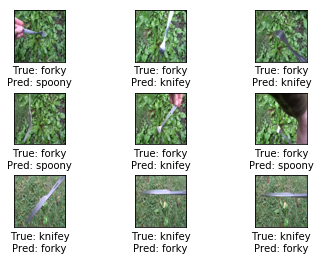

Confusion matrix:
[[145   3   3]
 [ 56  81   0]
 [ 46   7 189]]
(0) forky
(1) knifey
(2) spoony


In [68]:
example_errors()

### 1.9 Conclusión <a class="anchor" id="transferconclu"></a>

Este pequeño tutorial ha mostrado cómo usar la API de Keras para TensorFlow para realizar tanto transfer learning como fine tuning del modelo VGG16 pre-entrenado en un nuevo conjunto de datos. 

Que el fine tuning mejore la precisión de la clasificación en comparación con solo usar transfer learning depende del modelo pre-entrenado, de la capa de transferencia que se elija, del conjunto de datos y de la forma en que se entrena el nuevo modelo. Puede que se experimente un mejor rendimiento con el ajuste fino, o puede que experimente un peor rendimiento si el modelo ajustado está sobreajustado a los datos de entrenamiento.

## License (MIT)

Based on the TensorFlow tutorials by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.